In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold

%matplotlib inline

import os
os.listdir()

['.ipynb_checkpoints',
 'Cars.ipynb',
 'Ch_04.pdf',
 'Ch_06.pdf',
 'Ch_07.pdf',
 'Ch_08.pdf',
 'data',
 'datasets',
 'ex_ch3.pdf',
 'fetch_data.py',
 'first_time',
 'Glass.ipynb',
 'grant_submit.csv',
 'my_ch2 - A short tour.ipynb',
 'R_notebook.ipynb',
 'Segmentation Cells dataset.ipynb',
 'X2008_y2008_Xpre2008_ypre2008_Xall_yall_Xval_yval_cv.pkl',
 'Xtest.pkl']

In [65]:
import warnings
warnings.filterwarnings('ignore')

In [35]:
def boxcox_transform(x):
    return boxcox(x)[0]

class BoxCox(BaseEstimator, TransformerMixin):
    '''boxcox transformation using Sklearn API'''
    
    def __init__(self, col_names=None):
        '''
        col_names: a list of column names to apply boxcox transform
        '''
        self.col_names_ = col_names
        self.lambda_ = None
        
    def fit(self, X, y=None):
        '''
        X: pandas dataframe
        '''
        if self.col_names_ is not None:
            assert np.alltrue(pd.Series(self.col_names_).isin(X.columns))
        else:
            self.col_names_ = self._get_columns(X)
            
        self.lambda_ = []
        for col in self.col_names_:
            self.lambda_.append(boxcox_normmax(X[col]))
        return self
    
    def transform(self, X, y=None):
        assert self.lambda_ is not None, 'not fitted Boxcox'
        assert np.alltrue(pd.Series(self.col_names_).isin(X.columns))
        X_new = X.copy()
        for lam, c in zip(self.lambda_, self.col_names_):
            X_new[c] = boxcox(X[c], lam)
        return X_new
    
    def _get_columns(self, X):
        cols = [col for col, val in X.min().items() if val > 0]
        return cols
    
class BoxCox2(BaseEstimator, TransformerMixin):
    '''Boxcox version 2: automatically find skewed columns'''
    
    def __init__(self, skew_thresh=1.0):
        self.skew_thresh = skew_thresh
        self.target_cols_ = None
        self.all_cols_ = None
        self.lambdas_ = None
    
    def fit(self, X, y=None):
        self.all_cols_ = X.columns
        # get numeric columns
        cols_skew = self._get_target_columns(X)
        
        # get appropriate lambda for boxcox()
        self.lambdas_ = []
        for col in cols_skew:
            lam = boxcox_normmax(X[col])
            self.lambdas_.append(lam)
        return self
    
    def transform(self, X, y=None):
        assert np.alltrue(self.all_cols_.isin(X.columns))
        X_new = X.copy()
        for c, lam in zip(self.target_cols_, self.lambdas_):
            X_new[c] = boxcox(X[c], lam)
        return X_new
    
    def _get_target_columns(self, X):
        cols_by_skewness = X.skew(axis=0, numeric_only=True)
        cols_by_nunique = X.columns[X.nunique() > 10]
        cols_by_skewness = cols_by_skewness.index[cols_by_skewness.abs() >= self.skew_thresh]
        cols_by_min = X.describe().T['min'] > 0
        cols_by_min = cols_by_min.index[cols_by_min]
        self.target_cols_ = cols_by_nunique & cols_by_skewness & cols_by_min
        return self.target_cols_

In [274]:
# Dataset issues
# -----------
# X :
    # no missing values 
    # float variables: 
        # - skewness in many columns : plan = power transformation
        # - outliers in some columns : plan = try spatial sign
        # plan = scaling
    # int variables:
        # - binary feature [0,1] : plan = passthrough
        # - tertiary feature [0,1,2] : plan = onehot encoder
        # - more than 3 values features : 
            # - very skewed : plan = yeo-johnson transformation + scaling
    
# y : 2 class
    # unbalance: 63:37

#### Load Dataset and make [train, test]

In [39]:
segment = (pd.read_csv('datasets/segmentationOriginal/segmentationOriginal.csv', index_col=0)
               .drop(['MemberAvgAvgIntenStatusCh2', 'MemberAvgTotalIntenStatusCh2'], axis=1)    # drop single-value var
          )

In [40]:
segment.head()

,Cell,Case,Class,AngleCh1,AngleStatusCh1,AreaCh1,AreaStatusCh1,AvgIntenCh1,AvgIntenCh2,AvgIntenCh3,...,VarIntenCh1,VarIntenCh3,VarIntenCh4,VarIntenStatusCh1,VarIntenStatusCh3,VarIntenStatusCh4,WidthCh1,WidthStatusCh1,XCentroid,YCentroid
1,207827637,Test,PS,143.247705,1,185,0,15.711864,3.954802,9.548023,...,12.474676,7.609035,2.714100,0,2,2,10.642974,2,42,14
2,207932307,Train,PS,133.752037,0,819,1,31.923274,205.878517,69.916880,...,18.809225,56.715352,118.388139,0,0,0,32.161261,1,215,347
3,207932463,Train,WS,106.646387,0,431,0,28.038835,115.315534,63.941748,...,17.295643,37.671053,49.470524,0,0,0,21.185525,0,371,252
4,207932470,Train,PS,69.150325,0,298,0,19.456140,101.294737,28.217544,...,13.818968,30.005643,24.749537,0,0,2,13.392830,0,487,295
5,207932455,Test,PS,2.887837,2,285,0,24.275735,111.415441,20.474265,...,15.407972,20.504288,45.450457,0,0,0,13.198561,0,283,159


In [41]:
segment_train = segment.query('Case=="Train"').drop(['Cell', 'Case'], axis=1)
segment_test = segment.query('Case=="Test"').drop(['Cell', 'Case'], axis=1)

print("Train shape:{}\nTest shape:{}".format(segment_train.shape, segment_test.shape))

Train shape:(1009, 115)
Test shape:(1010, 115)


#### EDA

In [13]:
# not null values
segment_train.isnull().sum().describe()

count    117.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
dtype: float64

In [14]:
# distribution of target
segment_train.Class.value_counts(normalize=True)

PS    0.630327
WS    0.369673
Name: Class, dtype: float64

In [43]:
# seperate target variable from other independent variables
y_train = segment_train.pop('Class')

cols_by_dtypes = segment_train.dtypes
cols_by_dtypes.value_counts()

int64      65
float64    49
dtype: int64

In [44]:
int_cols = segment_train.select_dtypes('int64').columns
float_cols = segment_train.select_dtypes('float64').columns

print("{} int columns, {} float64 columns, total {} columns".format(len(int_cols), len(float_cols),
                                                                    len(int_cols)+len(float_cols)))

65 int columns, 49 float64 columns, total 114 columns


In [20]:
# EDA: float dtype columns
segment_train[float_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
AngleCh1,1009.0,91.126408,48.911900,0.030876,54.662403,90.028267,127.851585,179.939323
AvgIntenCh1,1009.0,127.915030,164.013579,15.171975,35.422594,62.343173,147.194030,1308.472050
AvgIntenCh2,1009.0,185.190674,153.986616,0.000000,41.002580,172.671010,274.652720,825.528846
AvgIntenCh3,1009.0,96.129169,93.535429,0.120000,33.716553,68.326034,126.339695,695.213793
AvgIntenCh4,1009.0,140.026045,149.178787,0.631579,39.163399,89.913295,185.513846,886.837500
ConvexHullAreaRatioCh1,1009.0,1.212608,0.209608,1.007653,1.066514,1.151515,1.290323,2.900320
ConvexHullPerimRatioCh1,1009.0,0.893498,0.077741,0.531966,0.854768,0.911344,0.955034,0.996499
DiffIntenDensityCh1,1009.0,73.665159,50.761540,26.732283,43.357843,56.025974,80.421233,442.773196
DiffIntenDensityCh3,1009.0,75.134946,67.318654,1.501377,30.045623,54.642857,98.045752,470.690476
DiffIntenDensityCh4,1009.0,86.555302,82.647892,2.710669,31.025568,59.750789,113.312883,531.346604


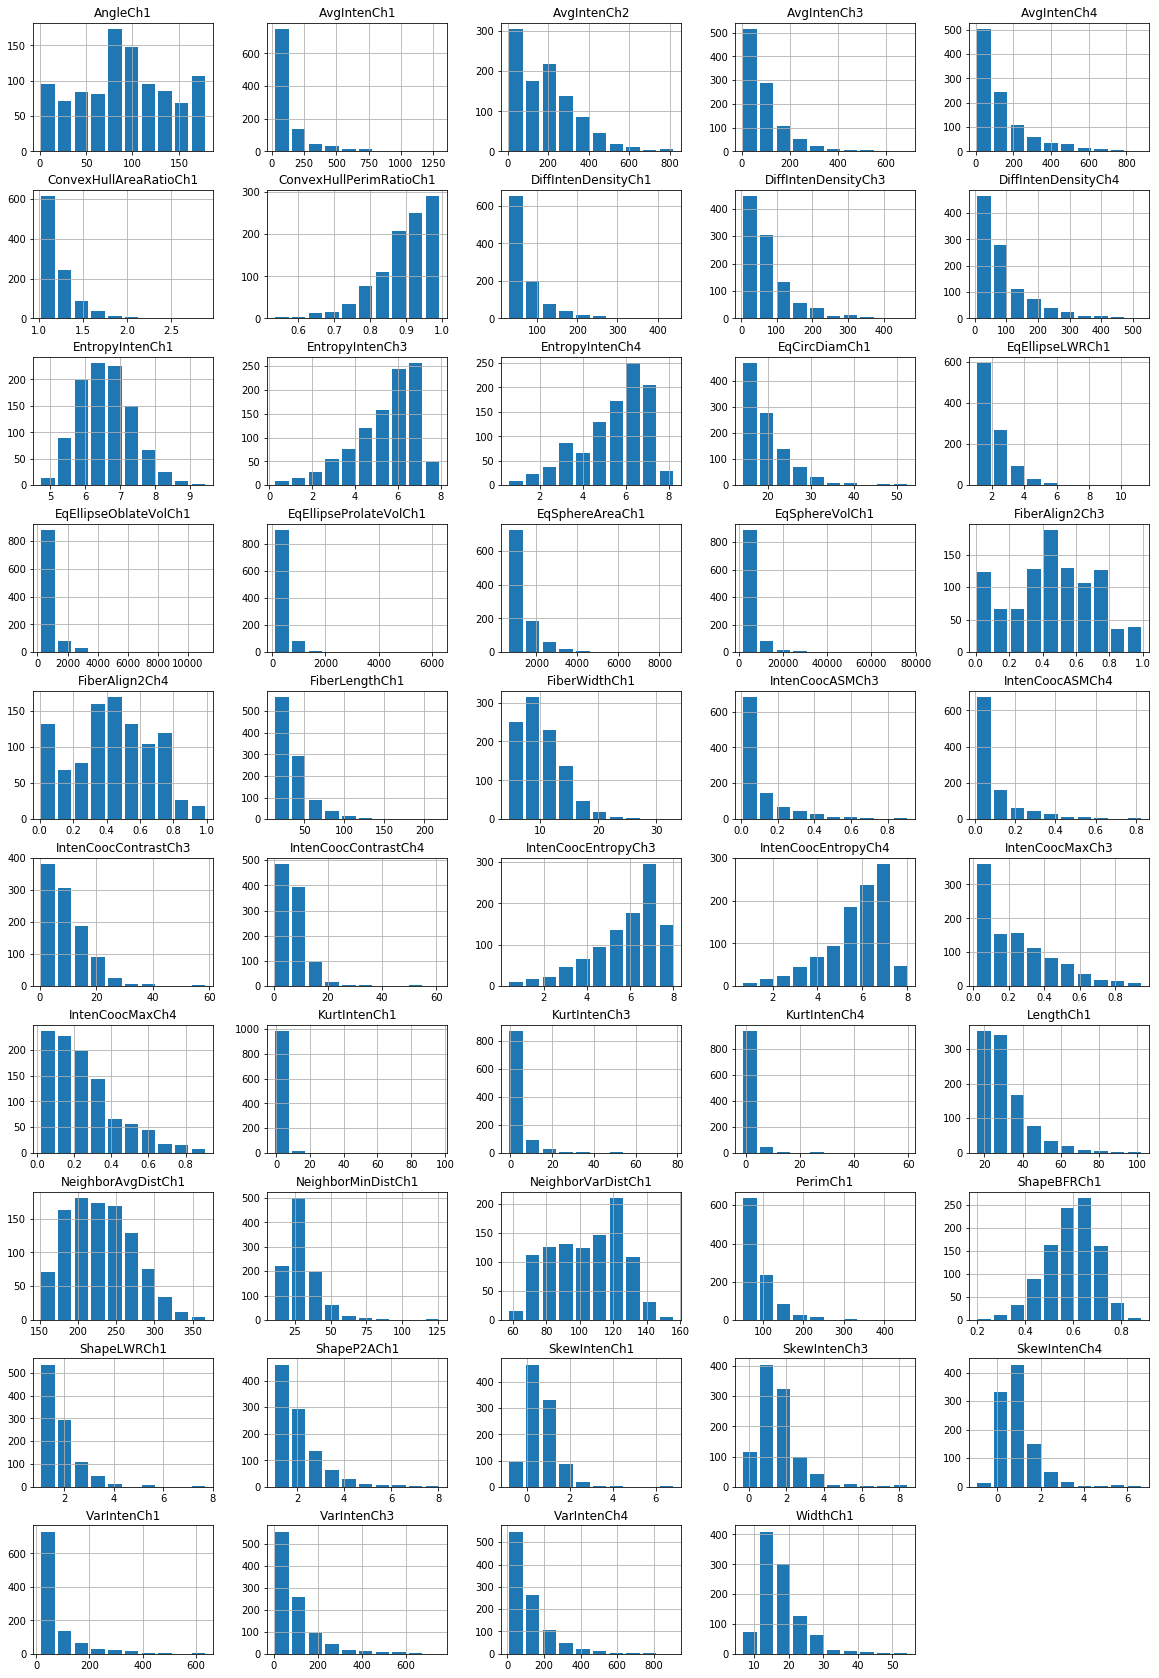

In [21]:
# 5 x 10
axs = segment_train[float_cols].hist(rwidth=.8, layout=(10, 5), figsize=(20, 30))

In [22]:
# summay statistics for skewness of float64 columns
segment_train[float_cols].skew().describe()

count    49.000000
mean      2.156896
std       2.443999
min      -1.307985
25%       0.850688
50%       2.168185
75%       2.597205
max      12.897971
dtype: float64

In [23]:
pt = PowerTransformer()

In [24]:
segment_flaot_powertrans = pd.DataFrame(pt.fit_transform(segment_train[float_cols]),
                                        columns=float_cols)

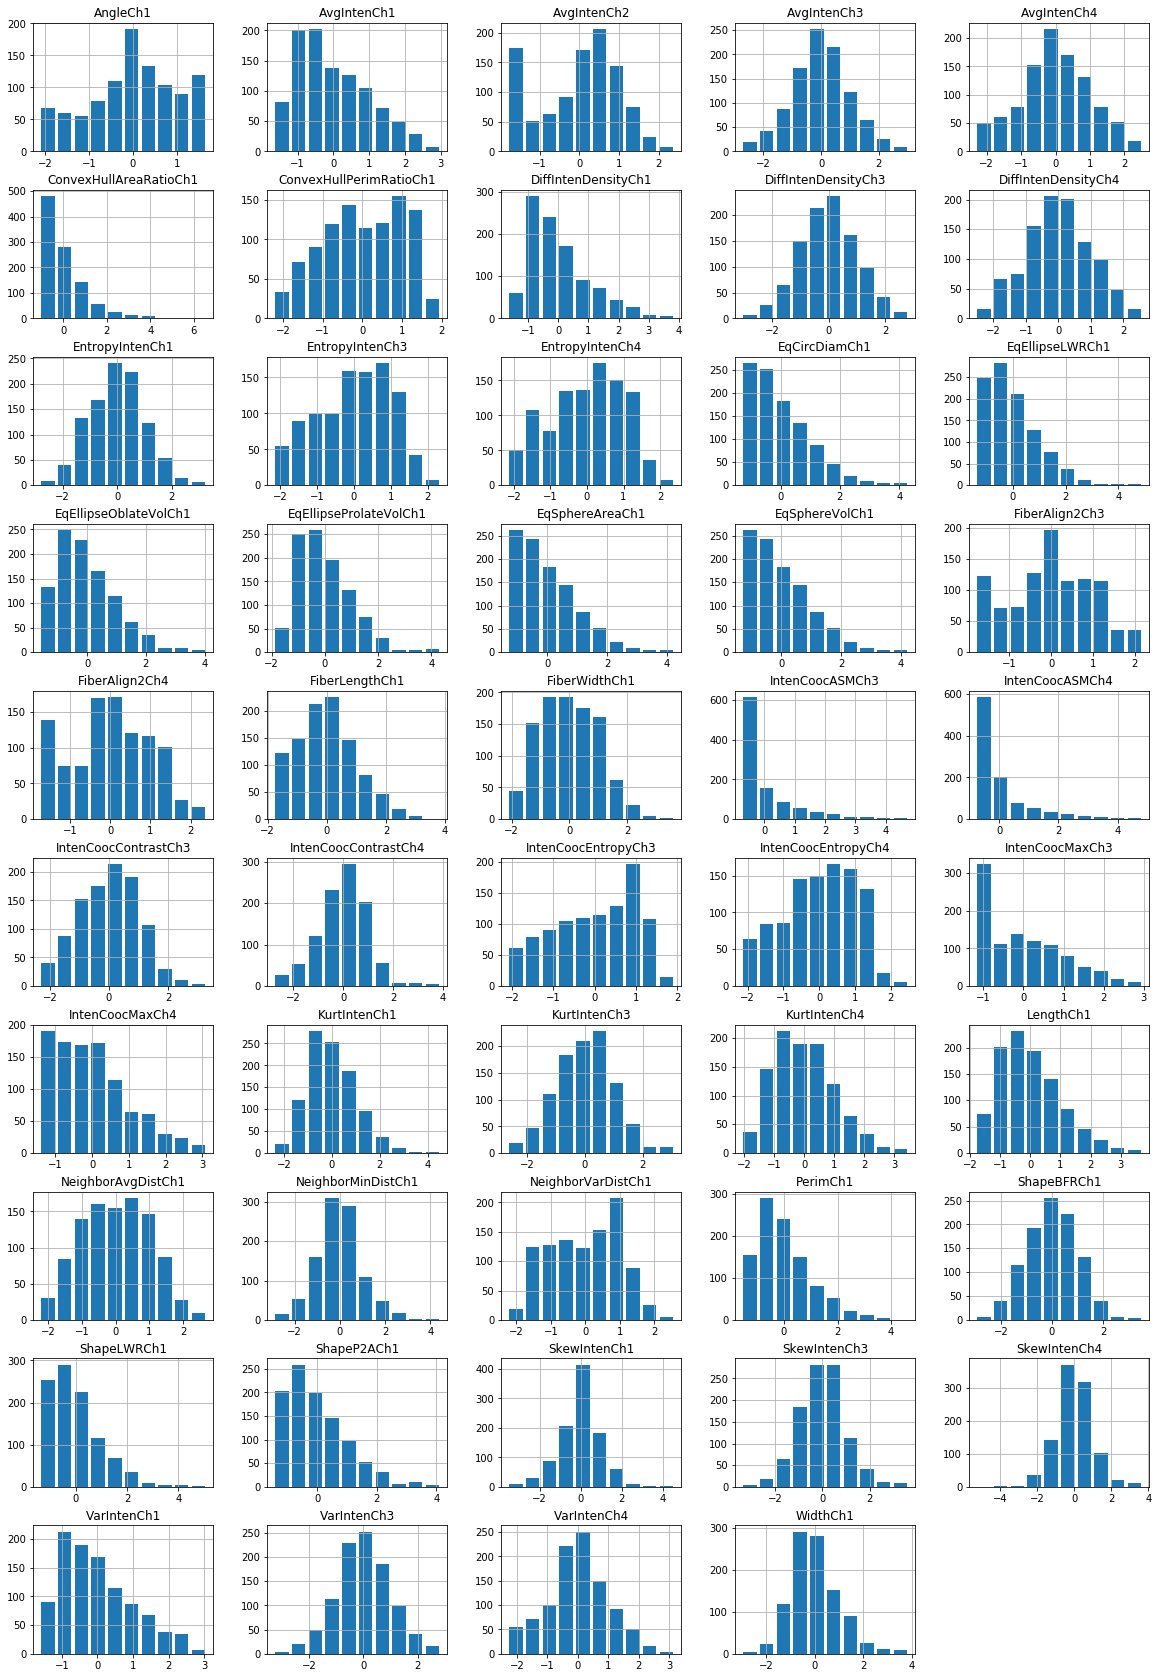

In [25]:
# histogram after performing yeo-johnson transformation
# most variables look normal distribution after transformation
# excepts some variables 
axs = segment_flaot_powertrans.hist(rwidth=.8, layout=(10, 5), figsize=(20, 30))

In [26]:
# summary statistics for skewness after yeo-johnson transformation
# showing improvement (less skewed features)
# mean : 2.15 -> 0.43
# std  : 2.44 -> .62
# max : 12.89 -> 2.11
segment_flaot_powertrans.skew().describe()

count    49.000000
mean      0.430259
std       0.621007
min      -0.342241
25%      -0.015364
50%       0.236305
75%       0.904624
max       2.118693
dtype: float64

In [28]:
# lambdas estimating from yeo-johnson transformation
pd.Series(pt.lambdas_, name='estimated lambdas').describe()

count    4.900000e+01
mean     6.839657e-01
std      2.087489e+00
min     -1.212724e-11
25%      5.317844e-09
50%      1.934004e-08
75%      2.273240e-01
max      1.377015e+01
Name: estimated lambdas, dtype: float64

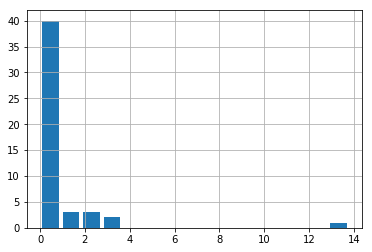

In [30]:
pd.Series(pt.lambdas_, name='estimated lambdas').hist(bins=15, rwidth=.8)

#### int64 columns

In [45]:
by_nunique = segment_train[int_cols].nunique()
by_nunique.value_counts()

3       41
2       15
1000     2
1003     1
362      1
999      1
420      1
31       1
399      1
11       1
dtype: int64

In [46]:
# found 2 single-value columns -> drop
by_nunique.index[by_nunique==1]

Index([], dtype='object')

In [47]:
# grouping columns by number of unique values
binary_cols = by_nunique.index[by_nunique==2]
tertiary_cols = by_nunique.index[by_nunique==3]
other_int_cols = by_nunique.index.difference(tertiary_cols.union(binary_cols))

print("{} binary columns".format(len(binary_cols)))
print('{} tertiary columns'.format(len(tertiary_cols)))
print("{} remaining columns".format(len(other_int_cols)))

15 binary columns
41 tertiary columns
9 remaining columns


In [54]:
# other int64 columns: skewness, looks like continuous features
segment_train[other_int_cols].describe()

,AreaCh1,SpotFiberCountCh3,SpotFiberCountCh4,TotalIntenCh1,TotalIntenCh2,TotalIntenCh3,TotalIntenCh4,XCentroid,YCentroid
count,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000
mean,325.125867,1.935580,5.948464,38882.623389,52658.123885,27173.704658,41135.769078,266.222002,178.696729
std,216.555276,1.614915,4.181322,66111.039917,46076.364198,27469.344813,47973.506746,139.266724,107.306319
min,150.000000,0.000000,1.000000,2382.000000,0.000000,24.000000,96.000000,11.000000,10.000000
25%,194.000000,1.000000,3.000000,9970.000000,13337.000000,9154.000000,9635.000000,149.000000,90.000000
50%,256.000000,2.000000,5.000000,19207.000000,50110.000000,19582.000000,26049.000000,271.000000,165.000000
75%,376.000000,3.000000,7.000000,37996.000000,73173.000000,35748.000000,56959.000000,386.000000,253.000000
max,2186.000000,13.000000,39.000000,741411.000000,362464.000000,209298.000000,519602.000000,501.000000,495.000000


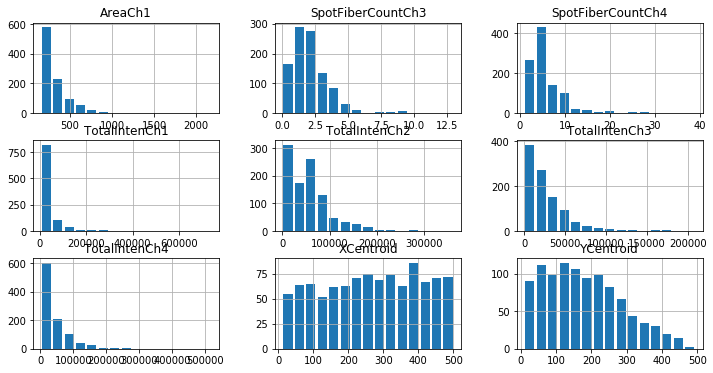

In [53]:
axs = segment_train[other_int_cols].hist(figsize=(12, 6), rwidth=.8, bins=15)

In [55]:
segment_train[other_int_cols].skew()

AreaCh1              3.535613
SpotFiberCountCh3    1.564664
SpotFiberCountCh4    2.629286
TotalIntenCh1        5.415695
TotalIntenCh2        1.449253
TotalIntenCh3        2.438919
TotalIntenCh4        3.158885
XCentroid           -0.105904
YCentroid            0.497131
dtype: float64

In [56]:
other_powertrans = pd.DataFrame(pt.fit_transform(segment_train[other_int_cols]), 
                                columns=other_int_cols)

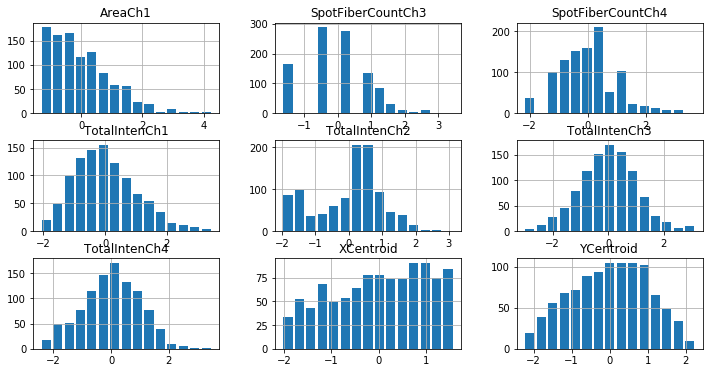

In [57]:
# histogram after yeo-johnson transformation -> much better , look normal distributions
axs = other_powertrans.hist(figsize=(12, 6), rwidth=.8, bins=15)

In [58]:
other_powertrans.skew()

AreaCh1              1.012132
SpotFiberCountCh3   -0.006968
SpotFiberCountCh4    0.263146
TotalIntenCh1        0.546509
TotalIntenCh2       -0.340664
TotalIntenCh3       -0.000111
TotalIntenCh4       -0.046939
XCentroid           -0.263326
YCentroid           -0.107384
dtype: float64

#### Preprocessing by dtype

In [66]:
float_transformer = PowerTransformer(method='yeo-johnson', standardize=True)
tertiary_transformer = OneHotEncoder(categories='auto')
other_transformer = PowerTransformer(method='yeo-johnson', standardize=True)

by_dtype_transformer = ColumnTransformer(transformers=[
    ('float_transformer', float_transformer, float_cols),
    ('tertiary_transformer', tertiary_transformer, tertiary_cols),
    ('other_int_transformer', other_transformer, other_int_cols),
    ],     
     remainder='passthrough' )

In [67]:
by_dtype_transformer.fit(segment_train)

ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('float_transformer', PowerTransformer(copy=True, method='yeo-johnson', standardize=True), Index(['AngleCh1', 'AvgIntenCh1', 'AvgIntenCh2', 'AvgIntenCh3', 'AvgIntenCh4',
       'ConvexHullAreaRatioCh1', 'ConvexHullPerimRatioCh1',
       'DiffIntenDensityCh1', 'DiffIntenDensityCh3', 'Di...tenCh2', 'TotalIntenCh3', 'TotalIntenCh4', 'XCentroid',
       'YCentroid'],
      dtype='object'))])

In [73]:
a = by_dtype_transformer.transform(segment_train)

In [76]:
by_dtype_transformer.named_transformers_

{'float_transformer': PowerTransformer(copy=True, method='yeo-johnson', standardize=True),
 'other_int_transformer': PowerTransformer(copy=True, method='yeo-johnson', standardize=True),
 'remainder': 'passthrough',
 'tertiary_transformer': OneHotEncoder(categorical_features=None, categories='auto',
        dtype=<class 'numpy.float64'>, handle_unknown='error',
        n_values=None, sparse=True)}

#### feature extraction: PCA

In [77]:
pca = PCA(n_components=.95)

In [78]:
a_pca = pca.fit_transform(a)

In [80]:
a_pca.shape

(1009, 48)

In [82]:
train_pca = pd.DataFrame(a_pca, columns=["PC{}".format(i) for i in range(1, a_pca.shape[1]+1)])
train_pca['target'] = y_train.values

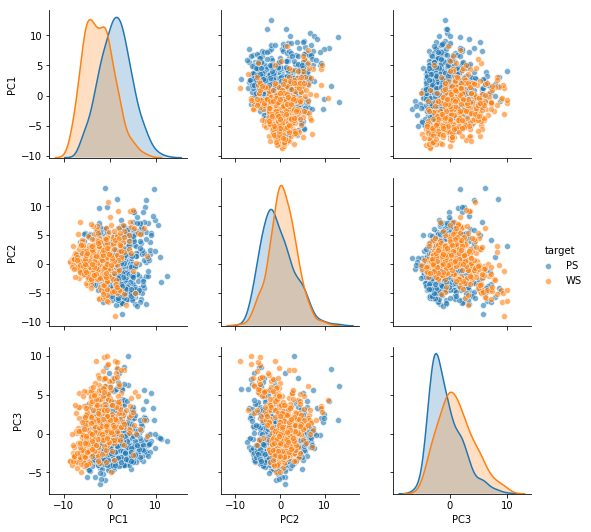

In [83]:
sns.pairplot(train_pca[['PC1', 'PC2', 'PC3', 'target']], 
             hue='target', plot_kws={'alpha':.6})

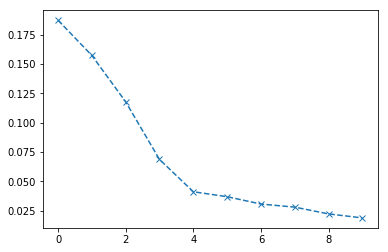

In [84]:
plt.plot(pca.explained_variance_ratio_[:10], 'x--')

#### Steps

* transfomation: boxcox
* normalize
* pca

* near zero variance
* remove correlated features

In [4]:
segment = pd.read_csv('datasets/segmentationOriginal/segmentationOriginal.csv', index_col=0)

In [5]:
segment.head()

,Cell,Case,Class,AngleCh1,AngleStatusCh1,AreaCh1,AreaStatusCh1,AvgIntenCh1,AvgIntenCh2,AvgIntenCh3,...,VarIntenCh1,VarIntenCh3,VarIntenCh4,VarIntenStatusCh1,VarIntenStatusCh3,VarIntenStatusCh4,WidthCh1,WidthStatusCh1,XCentroid,YCentroid
1,207827637,Test,PS,143.247705,1,185,0,15.711864,3.954802,9.548023,...,12.474676,7.609035,2.714100,0,2,2,10.642974,2,42,14
2,207932307,Train,PS,133.752037,0,819,1,31.923274,205.878517,69.916880,...,18.809225,56.715352,118.388139,0,0,0,32.161261,1,215,347
3,207932463,Train,WS,106.646387,0,431,0,28.038835,115.315534,63.941748,...,17.295643,37.671053,49.470524,0,0,0,21.185525,0,371,252
4,207932470,Train,PS,69.150325,0,298,0,19.456140,101.294737,28.217544,...,13.818968,30.005643,24.749537,0,0,2,13.392830,0,487,295
5,207932455,Test,PS,2.887837,2,285,0,24.275735,111.415441,20.474265,...,15.407972,20.504288,45.450457,0,0,0,13.198561,0,283,159


In [66]:
# Train / Test dataset
segment_train = segment.query('Case=="Train"').drop(['Cell', 'Case'], axis=1)
segment_test = segment.query('Case=="Test"').drop(['Cell', 'Case'], axis=1)

y_train = segment_train.pop('Class')
y_test = segment_test.pop('Class')

print("train:{}, test:{}".format(segment_train.shape, segment_test.shape))

train:(1009, 116), test:(1010, 116)


In [67]:
# remove '..Status..' features
segment_train = segment_train.loc[:, ~segment_train.columns.str.contains('Status')]
segment_test = segment_test.loc[:, ~segment_test.columns.str.contains('Status')]

print("Ater removing `Status` features:")
print("train:{}, test:{}".format(segment_train.shape, segment_test.shape))

Ater removing `Status` features:
train:(1009, 58), test:(1010, 58)


In [68]:
# all columns contain numeric values
segment_train.nunique().value_counts()

1009    35
399      4
1000     3
960      3
1008     2
951      1
1003     1
426      1
999      1
420      1
931      1
362      1
31       1
657      1
11       1
967      1
dtype: int64

In [69]:
skewness_before = segment_train.skew()

In [70]:
# transformation boxcox
boxcox_cols = (segment_test.min() > 0) & (segment_train.min() > 0)
boxcox_cols = boxcox_cols.index[boxcox_cols]

In [71]:
boxcox_transformer = BoxCox(boxcox_cols)

print("Transformations using boxcox: {} columns".format(len(boxcox_transformer.col_names_)))

Transformations using boxcox: 46 columns


In [75]:
skewness_after = boxcox_transformer.fit_transform(segment_train).skew()

In [76]:
# skewness before and after boxcox transformation
(pd.concat([skewness_before, skewness_after], axis=1)
     .rename(columns={0:'before',1:'after'})
     .describe()
)

,before,after
count,58.000000,58.000000
mean,2.177094,0.676677
std,2.329222,2.076643
min,-1.307985,-0.171607
25%,0.883156,-0.001279
50%,2.173174,0.031895
75%,2.671759,0.137188
max,12.897971,12.897971


In [90]:
# standard scaling
sc = StandardScaler()
sc.fit(segment_train)

# PCA
pca = PCA(n_components=.95)

In [91]:
boxcox_scale_pca = make_pipeline(boxcox_transformer,
                                 sc,
                                 pca)

In [92]:
a = boxcox_scale_pca.fit_transform(segment_train)

In [93]:
pd.Series(boxcox_transformer.lambda_).describe()

count    46.000000
mean      0.210327
std       1.631207
min      -4.203425
25%      -0.475648
50%      -0.014087
75%       0.368582
max       7.363377
dtype: float64

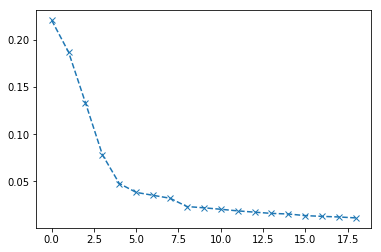

In [94]:
plt.plot(pca.explained_variance_ratio_, 'x--')

In [95]:
pca.explained_variance_ratio_.shape

(19,)

In [100]:
a.round(3)[:3, :5]

array([[ 1.665,  6.342, -0.371, -3.208, -1.223],
       [-0.644,  2.022, -1.521, -4.889, -1.619],
       [ 3.881, -0.534, -0.678, -4.075,  1.874]])

In [102]:
# zero variance
zero_var = VarianceThreshold(threshold=.05)

In [106]:
zero_var.fit(segment_train)

VarianceThreshold(threshold=0.05)

In [108]:
(zero_var.variances_ < .05).sum()

7

In [163]:
def find_high_correlation(df, cutoff=.75):
    cols = df.columns
    corrs = df.corr().abs()
    corrs_mean = corrs.mean()
    to_remove = set()
    cancidate_pairs = sorted([(i,j, corrs.iloc[i,j]) for i in range(len(corrs)) 
                          for j in range(i+1, len(corrs)) if corrs.iloc[i, j] >= cutoff],
                         key=lambda x: x[2], reverse=True)
    for i,j,_ in cancidate_pairs:
        if i in to_remove or j in to_remove:
            continue
        if corrs_mean[i] > corrs_mean[j]:
            to_remove.add(i)
        else:
            to_remove.add(j)
    print("found {} high correlated columns".format(len(to_remove)))
    return cols[list(to_remove)]

In [165]:
highcorr_cols = find_high_correlation(segment_train, cutoff=.75)

found 30 high correlated columns


In [166]:
new_corrs = segment_train.drop(highcorr_cols, axis=1).corr()

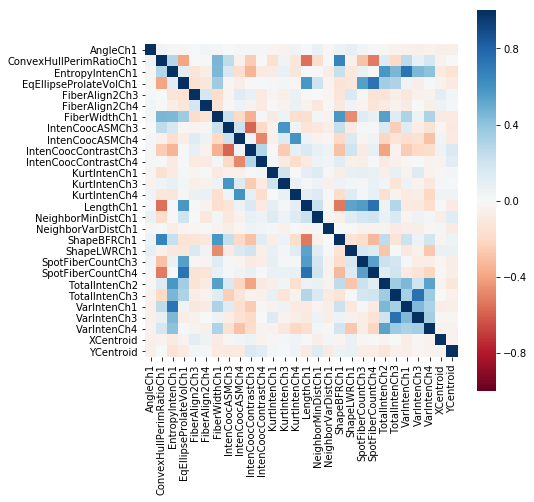

In [167]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(new_corrs, annot=False, square=True, 
            vmin=-1., vmax=1., cmap=plt.cm.RdBu, ax=ax)

In [168]:
highcorr_cols

Index(['AreaCh1', 'AvgIntenCh1', 'AvgIntenCh2', 'AvgIntenCh3', 'AvgIntenCh4',
       'ConvexHullAreaRatioCh1', 'DiffIntenDensityCh1', 'DiffIntenDensityCh3',
       'DiffIntenDensityCh4', 'EntropyIntenCh3', 'EntropyIntenCh4',
       'EqCircDiamCh1', 'EqEllipseLWRCh1', 'EqEllipseOblateVolCh1',
       'EqSphereAreaCh1', 'EqSphereVolCh1', 'FiberLengthCh1',
       'IntenCoocEntropyCh3', 'IntenCoocEntropyCh4', 'IntenCoocMaxCh3',
       'IntenCoocMaxCh4', 'NeighborAvgDistCh1', 'PerimCh1', 'ShapeP2ACh1',
       'SkewIntenCh1', 'SkewIntenCh3', 'SkewIntenCh4', 'TotalIntenCh1',
       'TotalIntenCh4', 'WidthCh1'],
      dtype='object')